In [5]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [6]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [7]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

In [8]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [9]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [10]:
preprocess("Thor ate pizza")

'thor eat pizza'

In [11]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

In [12]:
corpus_processed = [
    preprocess(text) for text in corpus
]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [13]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

In [14]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]], dtype=int64)

In [15]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [16]:
#Dataset
#Dataset Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

#This data consists of two columns. - Text - Category
#Text is a news article
#Category can be one of these 4: 'BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE', to keep things simple I trimmed additional categories from the original dataset

import pandas as pd

df = pd.read_json('news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [17]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

In [18]:
#Handle class imbalance

min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class


df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [19]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

In [20]:
#Convert text category to a number
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [21]:
df_balanced.head()

,text,category,category_num
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


In [23]:
#Build a model with original text (no pre processing)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [24]:
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [25]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [26]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

In [27]:
#Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [28]:
X_test[:5]

3716     African Nation Slaps Exxon With Fine Nearly 7 ...
608      These Cringe-Worthy Stories Show It Can Be Har...
11172    LISTEN: The Accidental Discovery That Proved T...
1346     Build Loyalty -- The Cost -- $00.00 Remember y...
1356     Man Killed By Michigan Police Wasn't Targeting...
Name: text, dtype: object

In [29]:
y_pred[:5]

array([0, 3, 3, 0, 2], dtype=int64)

In [30]:
y_test[:5]

3716     0
608      3
11172    3
1346     0
1356     2
Name: category_num, dtype: int64

In [31]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

In [32]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[249,   6,  13,   8],
       [ 32, 206,  33,   6],
       [ 28,   2, 242,   4],
       [ 52,   3,   7, 214]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

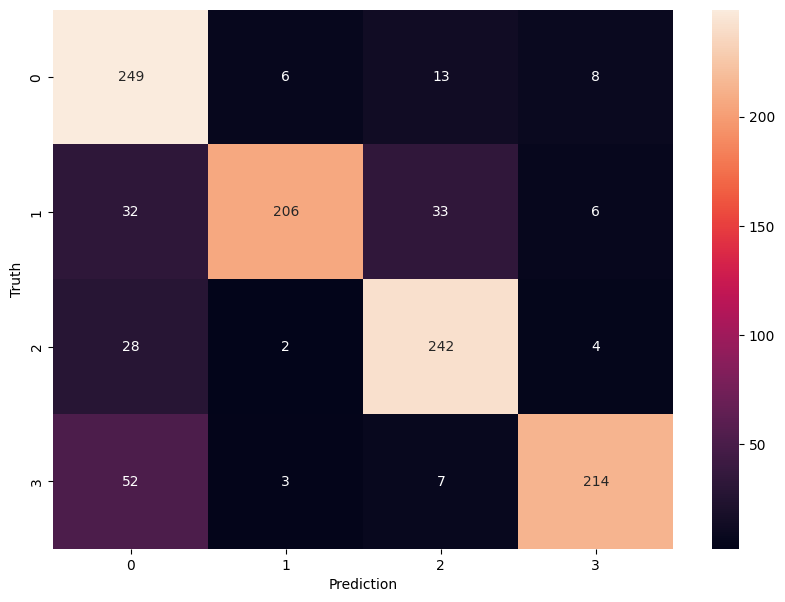

In [34]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')